In [1]:
# TODO Test LSTM for Feature Extraction
# Test both weighted and unweighted class approaches for better CV-LB estimation.
# Test PCA After automated feature extractor.
# Look at the feature importances of the autogenerated features.
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
import re
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
import featuretools as ft 
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import StratifiedKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import gc
from tsfresh import extract_relevant_features
from sklearn.decomposition import PCA

In [2]:
'''
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()
'''

'\ndef plot_confusion_matrix(truth, pred, classes, normalize=False, title=\'\'):\n    cm = confusion_matrix(truth, pred)\n    if normalize:\n        cm = cm.astype(\'float\') / cm.sum(axis=1)[:, np.newaxis]\n    \n    plt.figure(figsize=(10, 10))\n    plt.imshow(cm, interpolation=\'nearest\', cmap=plt.cm.Blues)\n    plt.title(\'Confusion matrix\', size=15)\n    plt.colorbar(fraction=0.046, pad=0.04)\n    tick_marks = np.arange(len(classes))\n    plt.xticks(tick_marks, classes, rotation=45)\n    plt.yticks(tick_marks, classes)\n\n    fmt = \'.2f\' if normalize else \'d\'\n    thresh = cm.max() / 2.\n    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):\n        plt.text(j, i, format(cm[i, j], fmt),\n                 horizontalalignment="center",\n                 color="white" if cm[i, j] > thresh else "black")\n\n    plt.ylabel(\'True label\')\n    plt.xlabel(\'Predicted label\')\n    plt.grid(False)\n    plt.tight_layout()\n'

In [3]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [4]:
def balanced_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score
'''
def lb_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score
'''

'\ndef lb_cv(conf_mat):\n    assert len(conf_mat.shape) == 2\n    rows, columns = conf_mat.shape\n    intra_class_scores = np.zeros((1, columns))\n    column_sums = np.sum(conf_mat, axis=0)\n    for c in range(columns):\n        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]\n        \n    balanced_score = np.mean(intra_class_scores)\n    return balanced_score\n'

In [5]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [6]:
data = pd.read_csv('X_train.csv')
target = pd.read_csv('y_train.csv')
sampl = pd.read_csv('sample_submission.csv')
test = pd.read_csv('X_test.csv')

In [12]:
totalt = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(5)

In [13]:
totalt = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(5)

In [14]:
# data.describe()

In [15]:
# target.describe()

In [16]:
# test.describe()

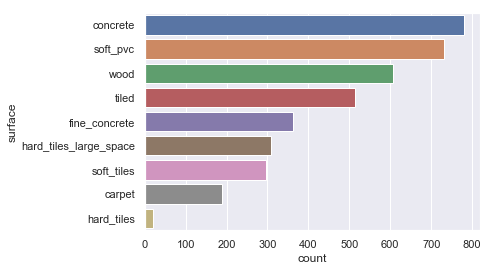

In [17]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

In [18]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [19]:
#Label Encoding
target['surface'] = le.fit_transform(target['surface'])

In [20]:
# print(data['row_id'].dtype)
data.drop(['row_id'],axis=1)
data = data.astype('float64')
test.drop(['row_id'],axis=1)
test = test.astype('float64')
'''
data[data['series_id'] == 0].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()
'''
data = extract_relevant_features(data, target['surface'], column_id='series_id', column_sort='measurement_number')
# data = extract_features(data, column_id="series_id", column_sort="measurement_number")
test = extract_features(test, column_id="series_id", column_sort="measurement_number")

Feature Extraction: 100%|█████████████████████████████████████████████████████████████| 10/10 [47:19<00:00, 241.86s/it]
 'angular_velocity_X__fft_coefficient__coeff_65__attr_"angle"'
 'angular_velocity_X__fft_coefficient__coeff_65__attr_"imag"' ...
 'row_id__fft_coefficient__coeff_99__attr_"angle"'
 'row_id__fft_coefficient__coeff_99__attr_"imag"'
 'row_id__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.
Feature Extraction: 100%|█████████████████████████████████████████████████████████████| 10/10 [46:19<00:00, 238.54s/it]


In [21]:
impute(data)
test = test[data.columns]

In [22]:
print(data.shape)
print(test.shape)

(3810, 3967)
(3816, 3967)


In [23]:
impute(test)

variable,"linear_acceleration_Y__fft_aggregated__aggtype_""kurtosis""",linear_acceleration_Y__ar_coefficient__k_10__coeff_4,linear_acceleration_Z__number_crossing_m__m_-1,linear_acceleration_Z__range_count__max_1000000000000.0__min_0,linear_acceleration_Z__number_crossing_m__m_0,linear_acceleration_Z__kurtosis,linear_acceleration_Z__sample_entropy,linear_acceleration_Z__range_count__max_1__min_-1,linear_acceleration_Z__number_crossing_m__m_1,linear_acceleration_Z__binned_entropy__max_bins_10,...,"angular_velocity_Y__fft_coefficient__coeff_52__attr_""abs""","angular_velocity_X__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","angular_velocity_Z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",angular_velocity_Z__partial_autocorrelation__lag_7,"linear_acceleration_Y__fft_coefficient__coeff_27__attr_""abs""","orientation_W__fft_coefficient__coeff_36__attr_""abs""",orientation_Z__has_duplicate_max,angular_velocity_X__number_peaks__n_50,orientation_Y__large_standard_deviation__r_0.35000000000000003,orientation_X__number_peaks__n_50
id,,,,,,,,,,,,,,,,,,,,,
0.0,4.174259,0.263469,0.0,0.0,0.0,0.033811,2.200675,0.0,0.0,1.989206,...,0.069407,0.000063,0.020658,0.030206,15.894278,0.000058,0.0,0.0,0.0,0.0
1.0,3.910221,0.465773,0.0,0.0,0.0,3.938843,1.848455,0.0,0.0,1.597875,...,0.063284,0.000047,0.009502,0.322257,12.890272,0.000993,0.0,1.0,0.0,0.0
2.0,4.940079,0.368609,0.0,0.0,0.0,-0.334135,2.227704,0.0,0.0,2.090874,...,0.009242,0.000217,0.030085,0.046391,7.987053,0.000225,0.0,0.0,0.0,0.0
3.0,6.973485,0.188812,0.0,0.0,0.0,0.117266,2.149771,0.0,0.0,2.049619,...,0.026972,0.000005,0.004995,0.345471,2.307964,0.000413,1.0,0.0,0.0,0.0
4.0,13.921085,0.050490,0.0,0.0,0.0,-0.544805,2.196241,0.0,0.0,2.139623,...,0.009286,0.000002,0.003676,0.114244,0.155827,0.003309,0.0,1.0,0.0,0.0
5.0,7.733730,0.014982,16.0,10.0,12.0,3.021466,1.930648,7.0,8.0,1.670568,...,0.665759,0.001479,0.088799,-0.198526,75.304283,0.004264,0.0,0.0,0.0,0.0
6.0,4.045355,0.556763,0.0,0.0,0.0,0.280195,2.163594,0.0,0.0,2.029961,...,0.042481,0.000043,0.012179,-0.205921,5.474197,0.000458,0.0,1.0,0.0,0.0
7.0,7.660025,0.517949,12.0,7.0,8.0,1.076434,2.098319,2.0,8.0,1.924538,...,0.344356,0.000167,0.037116,-0.344622,35.756486,0.002017,0.0,1.0,0.0,0.0
8.0,5.570375,0.411919,0.0,0.0,0.0,0.278045,2.201787,0.0,0.0,2.012131,...,0.043185,0.000009,0.006133,0.369107,7.963974,0.002400,0.0,0.0,0.0,0.0


In [24]:
test.head()

variable,"linear_acceleration_Y__fft_aggregated__aggtype_""kurtosis""",linear_acceleration_Y__ar_coefficient__k_10__coeff_4,linear_acceleration_Z__number_crossing_m__m_-1,linear_acceleration_Z__range_count__max_1000000000000.0__min_0,linear_acceleration_Z__number_crossing_m__m_0,linear_acceleration_Z__kurtosis,linear_acceleration_Z__sample_entropy,linear_acceleration_Z__range_count__max_1__min_-1,linear_acceleration_Z__number_crossing_m__m_1,linear_acceleration_Z__binned_entropy__max_bins_10,...,"angular_velocity_Y__fft_coefficient__coeff_52__attr_""abs""","angular_velocity_X__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","angular_velocity_Z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",angular_velocity_Z__partial_autocorrelation__lag_7,"linear_acceleration_Y__fft_coefficient__coeff_27__attr_""abs""","orientation_W__fft_coefficient__coeff_36__attr_""abs""",orientation_Z__has_duplicate_max,angular_velocity_X__number_peaks__n_50,orientation_Y__large_standard_deviation__r_0.35000000000000003,orientation_X__number_peaks__n_50
id,,,,,,,,,,,,,,,,,,,,,
0.0,4.174259,0.263469,0.0,0.0,0.0,0.033811,2.200675,0.0,0.0,1.989206,...,0.069407,0.000063,0.020658,0.030206,15.894278,0.000058,0.0,0.0,0.0,0.0
1.0,3.910221,0.465773,0.0,0.0,0.0,3.938843,1.848455,0.0,0.0,1.597875,...,0.063284,0.000047,0.009502,0.322257,12.890272,0.000993,0.0,1.0,0.0,0.0
2.0,4.940079,0.368609,0.0,0.0,0.0,-0.334135,2.227704,0.0,0.0,2.090874,...,0.009242,0.000217,0.030085,0.046391,7.987053,0.000225,0.0,0.0,0.0,0.0
3.0,6.973485,0.188812,0.0,0.0,0.0,0.117266,2.149771,0.0,0.0,2.049619,...,0.026972,0.000005,0.004995,0.345471,2.307964,0.000413,1.0,0.0,0.0,0.0
4.0,13.921085,0.050490,0.0,0.0,0.0,-0.544805,2.196241,0.0,0.0,2.139623,...,0.009286,0.000002,0.003676,0.114244,0.155827,0.003309,0.0,1.0,0.0,0.0


In [25]:
data.head()

variable,"linear_acceleration_Y__fft_aggregated__aggtype_""kurtosis""",linear_acceleration_Y__ar_coefficient__k_10__coeff_4,linear_acceleration_Z__number_crossing_m__m_-1,linear_acceleration_Z__range_count__max_1000000000000.0__min_0,linear_acceleration_Z__number_crossing_m__m_0,linear_acceleration_Z__kurtosis,linear_acceleration_Z__sample_entropy,linear_acceleration_Z__range_count__max_1__min_-1,linear_acceleration_Z__number_crossing_m__m_1,linear_acceleration_Z__binned_entropy__max_bins_10,...,"angular_velocity_Y__fft_coefficient__coeff_52__attr_""abs""","angular_velocity_X__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","angular_velocity_Z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",angular_velocity_Z__partial_autocorrelation__lag_7,"linear_acceleration_Y__fft_coefficient__coeff_27__attr_""abs""","orientation_W__fft_coefficient__coeff_36__attr_""abs""",orientation_Z__has_duplicate_max,angular_velocity_X__number_peaks__n_50,orientation_Y__large_standard_deviation__r_0.35000000000000003,orientation_X__number_peaks__n_50
id,,,,,,,,,,,,,,,,,,,,,
0.0,4.380422,0.428961,0.0,0.0,0.0,0.532135,2.064786,0.0,0.0,1.886415,...,0.042511,0.000005,0.008810,-0.136201,11.246732,0.000458,0.0,1.0,0.0,0.0
1.0,4.025493,0.582859,0.0,0.0,0.0,1.356800,2.069647,0.0,0.0,1.742458,...,0.108946,0.000187,0.022563,-5.745309,20.459582,0.000496,0.0,0.0,0.0,0.0
2.0,3.796316,0.237430,0.0,0.0,0.0,0.446304,2.171117,0.0,0.0,1.938753,...,0.056354,0.000005,0.013261,0.235563,9.868712,0.000730,0.0,0.0,0.0,0.0
3.0,4.367068,0.244946,2.0,0.0,0.0,0.670500,2.067700,1.0,0.0,1.942950,...,0.185335,0.000423,0.016507,0.244636,13.252955,0.000363,0.0,0.0,0.0,0.0
4.0,8.500632,0.313223,0.0,0.0,0.0,-0.486618,2.233428,0.0,0.0,2.182472,...,0.051665,0.000080,0.006978,1.259354,10.933978,0.000426,0.0,0.0,0.0,0.0


In [43]:
'''
pca = PCA(n_components=100)
datapca = pca.fit_transform(data.values)
testpca = pca.transform(test.values)
print(datapca.shape)
print(testpca.shape)
data_new = pd.DataFrame(datapca)
test_new = pd.DataFrame(testpca)
data_new.head()
test_new.head()
'''

(3810, 100)
(3816, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-4.717643e+18,3.132095e+13,1.860402e+08,435533.458874,989963.237394,-206639.786683,-15097.878155,-24280.187661,-30143.117203,11693.186413,...,116.143023,20.840715,-123.555174,-23.916160,104.399685,50.831185,-242.042873,-5.188642,260.607634,-20.767077
1,-4.717643e+18,3.132092e+13,1.855619e+08,238969.549421,-456959.698634,-98169.797691,-33886.251762,-14951.867466,-10067.808337,-2549.307073,...,-64.119615,6.936811,29.746398,59.771145,26.701512,-85.330888,19.363546,-24.932930,-68.009260,53.804015
2,-4.717643e+18,3.132082e+13,1.850729e+08,480772.179672,-100257.853258,-72031.426597,23026.080018,3871.308086,330911.307677,-27388.028338,...,1.418095,-173.162243,-46.148383,-130.322583,-87.751578,-23.773204,-29.648765,153.271763,-12.352224,-90.853138
3,-4.717643e+18,3.132067e+13,1.845865e+08,325387.724469,-174003.813941,-100132.445344,-18659.847035,-13907.195451,-13008.981471,-4104.404302,...,-21.104442,-35.540082,-19.542931,8.438649,-29.179156,2.665544,15.708819,-23.054119,-39.554045,46.681114
4,-4.717643e+18,3.132046e+13,1.841003e+08,260082.525343,-173775.758497,-98054.115037,-19109.325424,-14751.019981,-12779.170550,-3088.001800,...,-25.941551,-29.021299,-14.393101,15.432169,-61.299942,-69.050033,48.792090,-6.773630,-22.592948,48.748027


In [47]:
split_count = 5
folds = StratifiedKFold(n_splits=5, shuffle=True)
# folds = GroupShuffleSplit(n_splits=split_count)

Fold: 0 score: 0.9151436031331592
balanced cv score 0.9052623615479151
Fold: 1 score: 0.9150326797385621
balanced cv score 0.8856345088122641
Fold: 2 score: 0.9094488188976378
balanced cv score 0.9136185810884991
Fold: 3 score: 0.925
balanced cv score 0.9317358420925197
Fold: 4 score: 0.9114927344782034
balanced cv score 0.8950766446585902
Avg Accuracy 0.9152235672495126
Avg Balanced Accuracy 0.9062655876399577


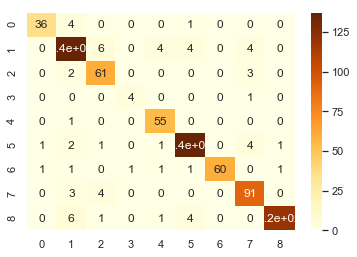

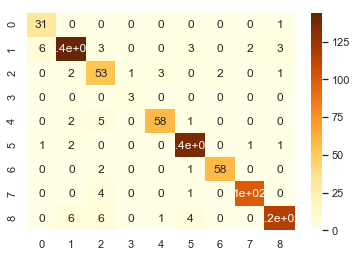

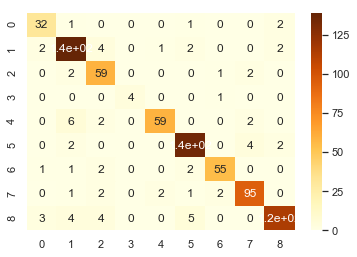

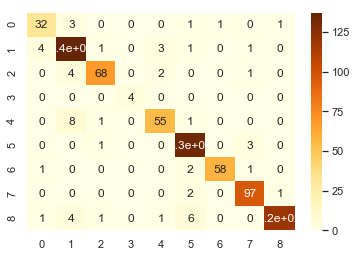

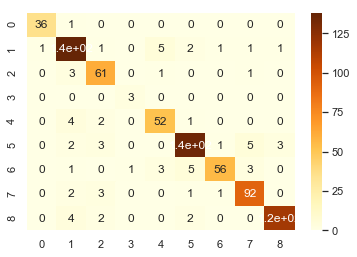

In [48]:
predicted = np.zeros((test.shape[0],9))
# measured= np.zeros((data.shape[0]))
score = 0
balanced_cv_sum = 0
# Balanced model training gives slightly worse results on pubLB.
model = RandomForestClassifier(n_estimators=200, class_weight = 'balanced')
# model = XGBClassifier(tree_method='gpu_hist')
# model = LGBMClassifier(device='gpu')
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    # measured[val_idx] = model.predict(data.iloc[val_idx])
    # predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))
    cm = confusion_matrix(model.predict(data.iloc[val_idx]), target['surface'].iloc[val_idx])
    plt.figure()
    sns.heatmap(cm, annot=True, cmap="YlOrBr")
    balscore = balanced_cv(cm)
    print('balanced cv score', balscore)
    balanced_cv_sum +=balscore
    gc.collect()
print('Avg Accuracy', score / folds.n_splits)
print('Avg Balanced Accuracy', balanced_cv_sum / folds.n_splits)

In [50]:
model.fit(data, target['surface'])
predicted = model.predict_proba(test)
sampl['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sampl.to_csv('submission.csv', index=False)
# sampl.head()